# Feature Engineering and Modelling

---

1. Import packages
2. Load data
3. Modelling

---

## 1. Import packages

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import class_weight
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# Shows plots in jupyter notebook
%matplotlib inline

# Set plot style
sns.set(color_codes=True)

---
## 2. Load data

In [3]:
df = pd.read_csv('./data_for_predictions.csv')
df.drop(columns=["Unnamed: 0"], inplace=True)
df.head()

,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,...,months_modif_prod,months_renewal,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw
0,24011ae4ebbe3035111d65fa7c15bc57,0.000000,4.739944,0.000000,0.000000,0.0,0.444045,0.114481,0.098142,40.606701,...,2,6,0,0,1,0,0,0,0,1
1,d29c2c54acc38ff3c0614d0a653813dd,3.668479,0.000000,0.000000,2.280920,0.0,1.237292,0.145711,0.000000,44.311378,...,76,4,1,0,0,0,0,1,0,0
2,764c75f661154dac3a6c254cd082ea7d,2.736397,0.000000,0.000000,1.689841,0.0,1.599009,0.165794,0.087899,44.311378,...,68,8,0,0,1,0,0,1,0,0
3,bba03439a292a1e166f80264c16191cb,3.200029,0.000000,0.000000,2.382089,0.0,1.318689,0.146694,0.000000,44.311378,...,69,9,0,0,0,1,0,1,0,0
4,149d57cf92fc41cf94415803a877cb4b,3.646011,0.000000,2.721811,2.650065,0.0,2.122969,0.116900,0.100015,40.606701,...,71,9,1,0,0,0,0,1,0,0


---

## 3. Modelling

We now have a dataset containing features that we have engineered and we are ready to start training a predictive model. Remember, we only need to focus on training a `Random Forest` classifier.

### Data sampling

The first thing we want to do is split our dataset into training and test samples. The reason why we do this, is so that we can simulate a real life situation by generating predictions for our test sample, without showing the predictive model these data points. This gives us the ability to see how well our model is able to generalise to new data, which is critical.

A typical % to dedicate to testing is between 20-30, for this example we will use a 75-25% split between train and test respectively.

In [4]:
# Make a copy of our data
train_df = df.copy()

# Separate target variable from independent variables
y = df['churn']
X = df.drop(columns=['id', 'churn'])
print(X.shape)
print(y.shape)

(14606, 61)
(14606,)


In [5]:
# Check class distribution
print(f"Churn class distribution: {y.value_counts()}")


Churn class distribution: churn
0    13187
1     1419
Name: count, dtype: int64


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(10954, 61)
(10954,)
(3652, 61)
(3652,)


### Model training

Once again, we are using a `Random Forest` classifier in this example. A Random Forest sits within the category of `ensemble` algorithms because internally the `Forest` refers to a collection of `Decision Trees` which are tree-based learning algorithms. As the data scientist, you can control how large the forest is (that is, how many decision trees you want to include).

The reason why an `ensemble` algorithm is powerful is because of the laws of averaging, weak learners and the central limit theorem. If we take a single decision tree and give it a sample of data and some parameters, it will learn patterns from the data. It may be overfit or it may be underfit, but that is now our only hope, that single algorithm. 

With `ensemble` methods, instead of banking on 1 single trained model, we can train 1000's of decision trees, all using different splits of the data and learning different patterns. It would be like asking 1000 people to all learn how to code. You would end up with 1000 people with different answers, methods and styles! The weak learner notion applies here too, it has been found that if you train your learners not to overfit, but to learn weak patterns within the data and you have a lot of these weak learners, together they come together to form a highly predictive pool of knowledge! This is a real life application of many brains are better than 1.

Now instead of relying on 1 single decision tree for prediction, the random forest puts it to the overall views of the entire collection of decision trees. Some ensemble algorithms using a voting approach to decide which prediction is best, others using averaging. 

As we increase the number of learners, the idea is that the random forest's performance should converge to its best possible solution.

Some additional advantages of the random forest classifier include:

- The random forest uses a rule-based approach instead of a distance calculation and so features do not need to be scaled
- It is able to handle non-linear parameters better than linear based models

On the flip side, some disadvantages of the random forest classifier include:

- The computational power needed to train a random forest on a large dataset is high, since we need to build a whole ensemble of estimators.
- Training time can be longer due to the increased complexity and size of thee ensemble

In [7]:
# Train the Random Forest model and evaluate its performance using cross-validation
rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_model.fit(X_train, y_train)


RandomForestClassifier(max_depth=5, random_state=42)

I chose the following evaluation metrics to assess the performance of the models:

Accuracy: 
This metric measures the overall correctness of the model's predictions. It is the ratio of the number of correct predictions to the total number of predictions.

Precision:
 Precision measures the proportion of true positive predictions out of all the positive predictions made by the model. It indicates how reliable the model's positive predictions are.
Recall:
 Recall measures the proportion of true positive predictions out of all the actual positive instances in the data. It indicates how well the model can identify positive instances.
 
F1-score:
 The F1-score is the harmonic mean of precision and recall. It provides a balanced measure of the model's performance, considering both precision and recall.

These metrics were chosen because they provide a comprehensive evaluation of the model's performance, covering different aspects of the model's predictive capabilities.
Accuracy is a straightforward metric, but it can be misleading in the case of imbalanced datasets. Precision, Recall, and F1-score provide a more nuanced understanding of the model's performance in identifying the positive and negative classes. AUC-ROC is a threshold-independent metric that measures the model's ability to distinguish between classes, which is particularly useful when dealing with imbalanced datasets.


 The combination of these metrics provides a comprehensive evaluation of the models, covering different aspects of their performance, such as accuracy, error magnitude, goodness of fit, and class-specific performance.
By using this set of evaluation metrics, I aimed to provide a thorough and well-rounded assessment of the machine learning model(s), enabling informed decision-making about their suitability for the given problem and dataset.

### Evaluation

Now let's evaluate how well this trained model is able to predict the values of the test dataset.

In [8]:
# Evaluate the model without addressing class imbalance
scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy')
y_pred = cross_val_predict(rf_model, X_train, y_train, cv=5)

accuracy = metrics.accuracy_score(y_train, y_pred)
f1 = metrics.f1_score(y_train, y_pred, average='weighted')
precision = metrics.precision_score(y_train, y_pred, average='weighted')
recall = metrics.recall_score(y_train, y_pred, average='weighted')
auc_roc = metrics.roc_auc_score(y_train, y_pred)

performance_df_original = pd.DataFrame({
    'Model': ['Random Forest'],
    'Accuracy': [accuracy],
    'F1-score': [f1],
    'Precision': [precision],
    'Recall': [recall],
    'AUC-ROC': [auc_roc]
})

print("Performance Metrics (Without Addressing Class Imbalance):")
print(performance_df_original)

# Address the Class Imbalance
smote = SMOTE(random_state=42)
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Evaluate the model after addressing class imbalance
scores = cross_val_score(rf_model, X_resampled, y_resampled, cv=5, scoring='accuracy')
y_pred = cross_val_predict(rf_model, X_resampled, y_resampled, cv=5)

accuracy = metrics.accuracy_score(y_resampled, y_pred)
f1 = metrics.f1_score(y_resampled, y_pred, average='weighted')
precision = metrics.precision_score(y_resampled, y_pred, average='weighted')
recall = metrics.recall_score(y_resampled, y_pred, average='weighted')
auc_roc = metrics.roc_auc_score(y_resampled, y_pred)

performance_df_resampled = pd.DataFrame({
    'Model': ['Random Forest'],
    'Accuracy': [accuracy],
    'F1-score': [f1],
    'Precision': [precision],
    'Recall': [recall],
    'AUC-ROC': [auc_roc]
})

print("\nPerformance Metrics (With Addressing Class Imbalance):")
print(performance_df_resampled)


Performance Metrics (Without Addressing Class Imbalance):
           Model  Accuracy  F1-score  Precision    Recall  AUC-ROC
0  Random Forest  0.903871  0.858233   0.816982  0.903871      0.5

Performance Metrics (With Addressing Class Imbalance):
           Model  Accuracy  F1-score  Precision    Recall   AUC-ROC
0  Random Forest  0.812645  0.812401    0.81428  0.812645  0.812645


The original Random Forest model, while achieving high accuracy, is heavily biased towards the majority class and struggling to distinguish between the classes, as indicated by the low AUC-ROC score. 
This is a common issue when dealing with imbalanced datasets, where the model can achieve high accuracy by simply predicting the majority class.

After addressing the class imbalance, the model's performance on the minority class and its ability to distinguish between the classes improved, as evidenced by the increase in the AUC-ROC score. 
However, this came at the cost of a decrease in overall accuracy, which is a common trade-off when dealing with imbalanced datasets.

The improved AUC-ROC score suggests that the model is now better equipped to handle the class imbalance and provide more reliable predictions, especially for the minority class, which is often the more important class in real-world applications.

In [ ]:
predictions = rf_model.predict(X_test)
tn, fp, fn, tp = metrics.confusion_matrix(y_test, predictions).ravel()

In [ ]:
y_test.value_counts()

0    3286
1     366
Name: churn, dtype: int64

In [ ]:
print(f"True positives: {tp}")
print(f"False positives: {fp}")
print(f"True negatives: {tn}")
print(f"False negatives: {fn}\n")

print(f"Accuracy: {metrics.accuracy_score(y_test, predictions)}")
print(f"Precision: {metrics.precision_score(y_test, predictions)}")
print(f"Recall: {metrics.recall_score(y_test, predictions)}")

True positives: 18
False positives: 4
True negatives: 3282
False negatives: 348

Accuracy: 0.9036144578313253
Precision: 0.8181818181818182
Recall: 0.04918032786885246


### Model understanding

A simple way of understanding the results of a model is to look at feature importances. Feature importances indicate the importance of a feature within the predictive model, there are several ways to calculate feature importance, but with the Random Forest classifier, we're able to extract feature importances using the built-in method on the trained model. In the Random Forest case, the feature importance represents the number of times each feature is used for splitting across all trees.

In [10]:
# Extract feature importances
feature_importances = pd.DataFrame({
    'features': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values(by='importance', ascending=True).reset_index()
print("\nFeature Importances:")
print(feature_importances)


Feature Importances:
    index                                    features  importance
0       9                                     has_gas    0.001332
1      30                   var_6m_price_mid_peak_fix    0.001677
2      57    channel_usilxuppasemubllopkaafesmlibmsdf    0.002079
3      29                       var_6m_price_peak_fix    0.002270
4      46          peak_mid_peak_fix_max_monthly_diff    0.002316
..    ...                                         ...         ...
56      5                     forecast_meter_rent_12m    0.037754
57     60  origin_up_lxidpiddsbxsbosboudacockeimpuepw    0.039881
58     49                                months_activ    0.057883
59     11                        margin_gross_pow_ele    0.087387
60     12                          margin_net_pow_ele    0.090011

[61 rows x 3 columns]


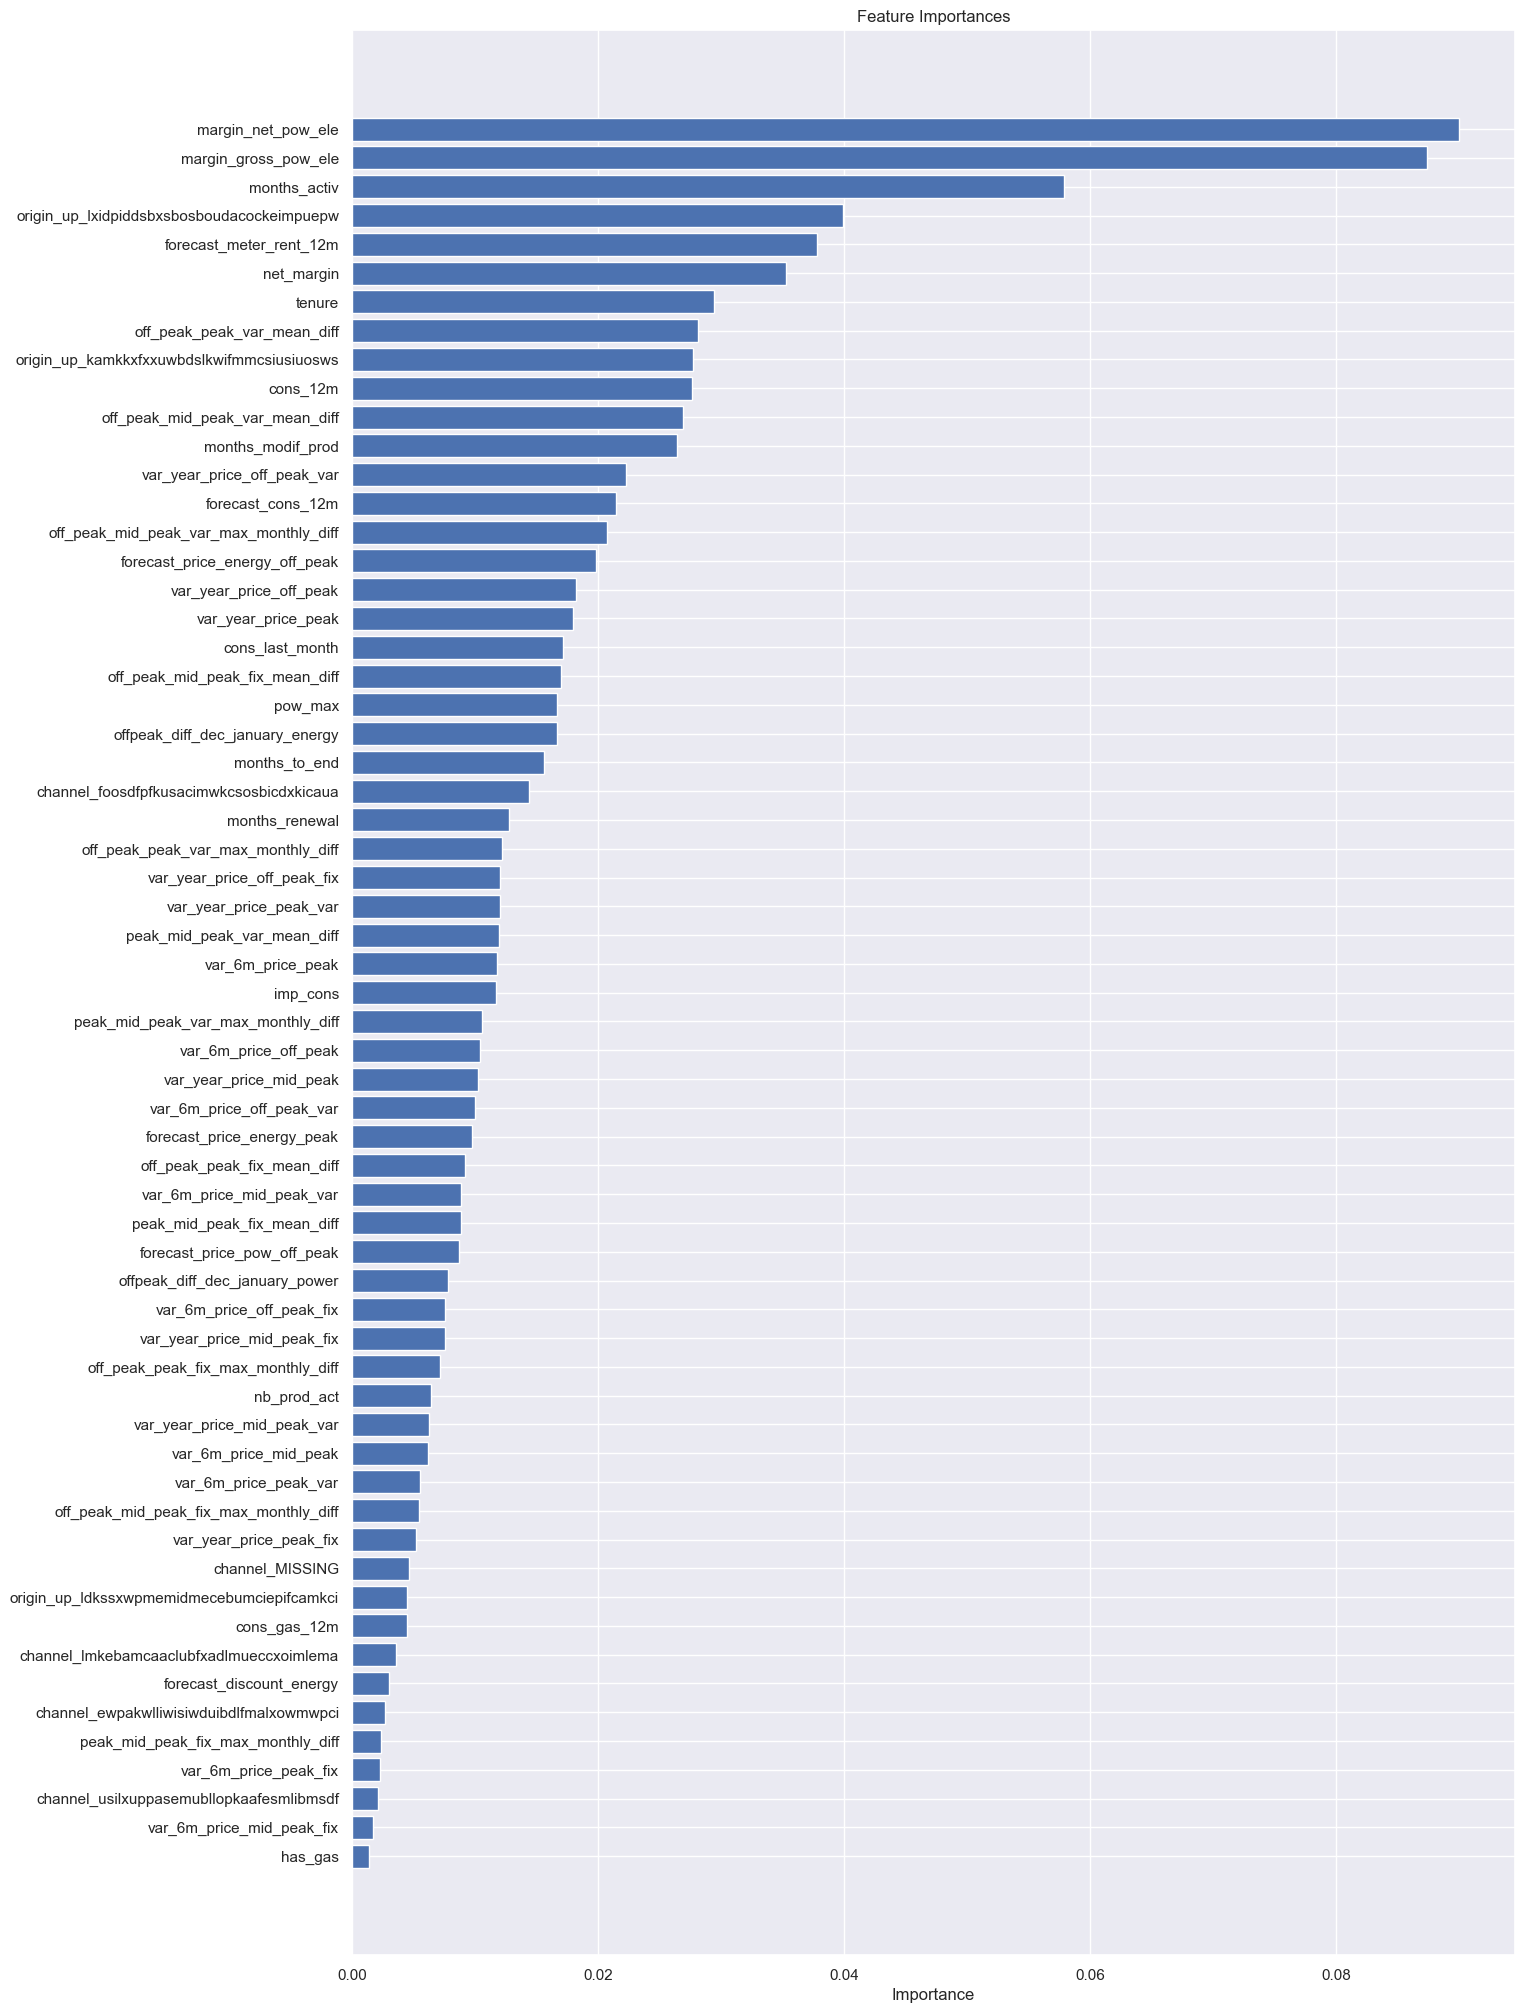

In [11]:
plt.figure(figsize=(15, 25))
plt.title('Feature Importances')
plt.barh(range(len(feature_importances)), feature_importances['importance'], color='b', align='center')
plt.yticks(range(len(feature_importances)), feature_importances['features'])
plt.xlabel('Importance')
plt.show()

From this chart, we can observe the following points:

- Net margin and consumption over 12 months is a top driver for churn in this model
- Margin on power subscription also is an influential driver
- Time seems to be an influential factor, especially the number of months they have been active, their tenure and the number of months since they updated their contract
- The feature that our colleague recommended is in the top half in terms of how influential it is and some of the features built off the back of this actually outperform it
- Our price sensitivity features are scattered around but are not the main driver for a customer churning

The last observation is important because this relates back to our original hypothesis:

    > Is churn driven by the customers' price sensitivity?

Based on the output of the feature importances, it is not a main driver but it is a weak contributor. However, to arrive at a conclusive result, more experimentation is needed.

In [ ]:
proba_predictions = rf_model.predict_proba(X_test)
probabilities = proba_predictions[:, 1]

In [ ]:
X_test = X_test.reset_index()
X_test.drop(columns='index', inplace=True)

In [ ]:
X_test['churn'] = predictions.tolist()
X_test['churn_probability'] = probabilities.tolist()
X_test.to_csv('out_of_sample_data_with_predictions.csv')